In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
image = plt.imread('../raw_data/Mushrooms/Agaricus/000_ePQknW8cTp8.jpg')

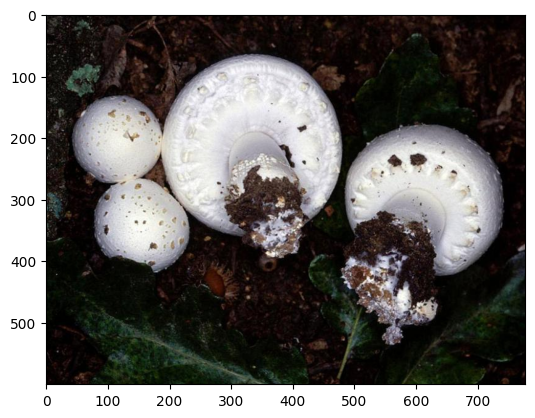

In [3]:
plt.imshow(image)

In [4]:
image.shape

(600, 778, 3)

In [15]:
# _X = []
# _y = []

# idx = 0
# for genus in os.listdir("../raw_data/Mushrooms"):
#     for image in os.listdir(f"../raw_data/Mushrooms/{genus}"):
#         try:
#             temp_img = plt.imread( os.path.join("../raw_data/Mushrooms", genus , image) )
#             if len(temp_img.shape) < 3 :
#                 continue
#             trans_img = cv2.resize( temp_img , (400,400) , interpolation = cv2.INTER_AREA)
#             _X.append(trans_img)
#             _y.append(genus)
#             idx += 1
#         except Exception:
#             print(f"exception cannot process : {image} in {genus}")
#             continue

# X = np.concatenate(_X , axis = 0).reshape((idx, 400,400,3))
# y = np.array(_y)

exception cannot process : 092_43B354vYxm8.jpg in Russula


In [8]:
_X = []
_y = []

idx = 0
for genus in os.listdir("../raw_data/Mushrooms"):
    for image in os.listdir(f"../raw_data/Mushrooms/{genus}"):
        temp_img = plt.imread( os.path.join("../raw_data/Mushrooms", genus , image) )
        if len(temp_img.shape) < 3 :
                continue
        trans_img = cv2.resize( temp_img , (400,400) , interpolation = cv2.INTER_AREA)
        _X.append(trans_img)
        _y.append(genus)
        idx += 1

X = np.concatenate(_X , axis = 0).reshape((idx, 400,400,3))
y = np.array(_y)

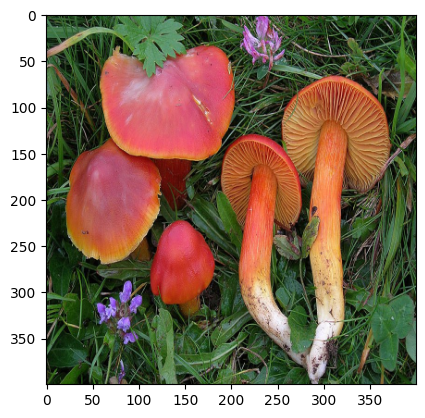

In [6]:
plt.imshow(X[0])

In [12]:
# save processed images in a file can be loaded with np.load(file.npy)
# type "mkdir processed" first in the terminal
np.save("processed/X.npy", X)
np.save("processed/y.npy", y)